In [9]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import random

In [44]:
regr.predict([[-0.000124,0.000580]])

array([-0.00010699])

In [42]:
 # Importing the dataset
df = pd.read_csv('ard_not_adv.csv', skiprows = 0)
df = df[df.amf_sn!=0]
df.sort_values(by=['amf_rh'],ascending=False)

,Unnamed: 0,amf_no,amf_ra,amf_dec,amf_z,amf_lk,amf_rh,amf_r200,amf_rc,amf_c,...,mcxc_id,red_id,whl_id,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353
0,0,5.0,260.6324,32.1398,0.2252,222.1219,200.7117,1.784,0.625,2.856,...,J1722.4+3208,RMJ172227.2+320757.2,J172227.2+320757,31.846666,55.602221,24.655148,-0.000048,1.978746,-0.000006,0.001062
1,1,7.0,250.1485,46.6917,0.2248,225.9874,182.3373,1.725,0.495,3.483,...,J1640.3+4642,RMJ164019.8+464241.5,J164019.8+464242,41.429880,72.599428,44.674799,-0.000269,1.196847,-0.000215,0.000722
3,3,10.0,203.1873,50.5346,0.3110,164.8704,179.1883,1.663,0.422,3.939,...,J1332.7+5032,RMJ133238.4+503336.0,J133252.1+503134,65.305106,107.103759,25.696075,-0.000124,1.019871,-0.000129,0.000580
4,4,12.0,350.2432,29.2029,0.5231,165.0015,174.7108,1.518,0.390,3.892,...,-9999,RMJ232104.1+291134.5,J232104.1+291134,-29.646780,100.211077,13.793623,0.000047,4.913466,0.000091,0.001929
5,5,13.0,139.4938,51.7236,0.2574,169.5809,172.6889,1.676,0.199,8.424,...,J0917.8+5143,RMJ091753.4+514337.5,J091753.4+514338,43.387615,166.090009,20.839521,0.000029,1.074994,0.000060,0.000894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21533,21533,54265.0,117.7965,28.4314,0.4498,21.3133,20.0019,0.721,0.090,8.015,...,-9999,-9999,J075110.0+282537,24.760679,192.272829,0.235375,-0.000085,1.742793,-0.000074,0.000728
21534,21534,54266.0,10.2234,16.4729,0.3325,7.5789,20.0018,0.754,0.420,1.796,...,-9999,-9999,J004043.6+162754,-46.323866,119.270217,1.128670,-0.000071,1.821485,-0.000079,0.000611
21535,21535,54272.0,332.5373,16.8053,0.2720,19.0528,20.0008,0.774,0.059,13.136,...,-9999,-9999,J221009.3+165449,-31.180104,76.542726,0.327218,-0.000112,2.181500,-0.000118,0.000789
21536,21536,54273.0,321.0614,-5.5885,0.4036,7.3319,20.0008,0.734,0.260,2.823,...,-9999,-9999,J212412.8-053647,-36.312474,46.861993,0.906488,0.000283,3.162386,0.000297,0.001527


In [32]:
X = df[['intensity100', 'intensity353']]
y = df['intensity143']

In [33]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
regr.predict([[-0.0001,0.0005]])

array([-8.53902987e-05])

In [35]:
intensity143 = [regr.predict([[i,j]]) for i, j in X.values]

<IPython.core.display.Javascript object>


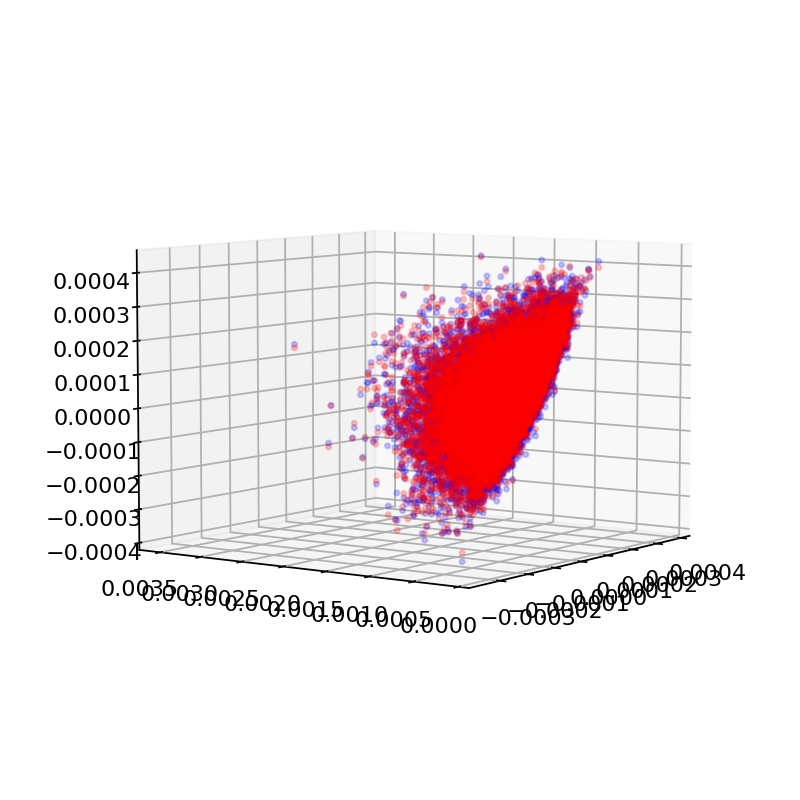

In [40]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['intensity100'], df['intensity353'], df['intensity143'],s=5,c='b', alpha=0.2)
ax.scatter(df['intensity100'], df['intensity353'], intensity143, s=5, c='r', alpha=0.2)
plt.show()

In [52]:
i = np.full(shape=21006,fill_value=100,dtype=np.int)
j = np.full(shape=21006,fill_value=143,dtype=np.int)
k = np.full(shape=21006,fill_value=353,dtype=np.int)

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

In [53]:
df['intensity100']

0       -0.000048
1       -0.000269
3       -0.000124
4        0.000047
5        0.000029
           ...   
21533   -0.000085
21534   -0.000071
21535   -0.000112
21536    0.000283
21537   -0.000005
Name: intensity100, Length: 21006, dtype: float64

In [56]:
plt.scatter(df['intensity100'],)

TypeError: scatter() missing 1 required positional argument: 'y'